# Industrial Safety Analysis

Uma análise dos indicadores de Segurança e Sáude ocupacional de uma Indústria.
| _An analysis of the Health and Safety indicators of an Industry._

# 1. Entendimento do Problema e Motivação

Os acidentes em indústria são situações que colocam em risco a saúde e a segurança dos trabalhadores, podendo causar lesões, doenças ou até mesmo mortes. Eles ocorrem devido à exposição a agentes nocivos, como eletricidade, ruído, calor, produtos químicos, máquinas, objetos e alturas. 

Alguns dos acidentes mais comuns na indústria são queda de altura, choque elétrico, queda de objetos, cortes, contusões e amputações, esses acidentes geram prejuízos para os trabalhadores, as empresas, a previdência social e a economia. 

Por isso, é extremamente importante preveni-los, adotando medidas de proteção coletiva e individual, seguindo as normas regulamentadoras, realizando treinamentos e fiscalizações, e promovendo uma cultura de segurança e saúde no trabalho.

Sabendo da importância desse tópico, esse estudo se propõe a analisar e sugerir sugestões de resolução para os seguintes tópicos de interesse:

$\bullet$ Analisar quais os setores da indústria mais propensos a acidentes;

$\bullet$ Analisar a distribuição temporal dos acidentes ao longo do tempo;

$\bullet$ Verificar quais as categorias tem mais influência no número de acidentes;

$\bullet$ **Construção de um modelo de previsão de acidentes futuros com base no país, setor da indústria, nível do acidente, potencial do nível do acidente, gênero do acidentado e risco crítico;**

# Fonte

Para este estudo, foi utilizado o dataset disponibilizado no Kaggle por IHM Stefanini em 
https://www.kaggle.com/datasets/ihmstefanini/industrial-safety-and-health-analytics-database

# 2. Obtenção dos Dados

Antes de se iniciar os estudos, iremos realizar a importação das bibliotecas que iremos precisar.

Caso esse notebook seja executado em uma máquina diferente, na próxima linha de código além das importações das bibliotecas, o código trará o Download automático de tais bibliotecas, conforme a seguir.

In [64]:
!pip install pandas matplotlib numpy seaborn scipy scikit-learn graphviz imbalanced-learn

In [65]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import random
import graphviz
from scipy.stats import norm, kendalltau, chi2_contingency, randint
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.utils.multiclass import unique_labels
from collections import Counter
import pickle

#Importações para uso do algoritmo de Random Forest
from sklearn.ensemble import RandomForestClassifier
from imblearn.ensemble import BalancedRandomForestClassifier
from imblearn.under_sampling import RandomUnderSampler
from sklearn import tree
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score, GridSearchCV

# Importações para o uso do algoritmo de Naive-Bayes
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import f1_score

## Importação dos dados
Iremos realizar a importação dos dados com o Pandas para começarmos a fazer a análise dos dados.

In [66]:
df = pd.read_csv('IHMStefanini_industrial_safety_and_health_database.csv', sep=',')
df.head(10)

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee ou Terceiro,Risco Critico
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others
5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems
6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level)
7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed
8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others
9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances


Como podemos observar acima, não há nenhuma coluna com valor vazio, Porém para mantermos a coesão, iremos nomear algumas colunas em inglês para facilitar a manipulação e a padronização dos dados.

In [67]:
df.rename(columns={
    'Employee ou Terceiro': 'Employee Type',
    'Risco Critico': 'Critical Risk'
}, inplace=True)

df.head(10)

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee Type,Critical Risk
0,2016-01-01 00:00:00,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06 00:00:00,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08 00:00:00,Country_01,Local_04,Mining,I,I,Male,Third Party,Others
4,2016-01-10 00:00:00,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Others
5,2016-01-12 00:00:00,Country_02,Local_05,Metals,I,III,Male,Third Party (Remote),Pressurized Systems
6,2016-01-16 00:00:00,Country_02,Local_05,Metals,I,III,Male,Employee,Fall prevention (same level)
7,2016-01-17 00:00:00,Country_01,Local_04,Mining,I,III,Male,Third Party,Pressed
8,2016-01-19 00:00:00,Country_02,Local_02,Mining,I,IV,Male,Third Party (Remote),Others
9,2016-01-26 00:00:00,Country_01,Local_06,Metals,I,II,Male,Third Party,Chemical substances


Como podemos perceber agora o nosso dataset está homogêneo na titulação das categorias com descritivos em inglês.

# 3. Análise Exploratória dos Dados - EDA

Nesse etapa, iremos realizar a exploração dos dados da seguinte forma:

* Identificação dos tipos de dados presentes no Dataframe(númericos, categóricos ou temporal).
* Identificar a variável-alvo (_Target_) do nosso problema definido.
* Exploração dos dados (medidas descritivas, distribuição das variáveis).
* Correlações e Relacionamentos.
* Manuseio de dados ânomalos.

## 3.1 Identificação das Variáveis presentes no Dataset

In [68]:
pd.DataFrame.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Data                      439 non-null    object
 1   Countries                 439 non-null    object
 2   Local                     439 non-null    object
 3   Industry Sector           439 non-null    object
 4   Accident Level            439 non-null    object
 5   Potential Accident Level  439 non-null    object
 6   Genre                     439 non-null    object
 7   Employee Type             439 non-null    object
 8   Critical Risk             439 non-null    object
dtypes: object(9)
memory usage: 31.0+ KB


A categoria "Data" deve ser tratada como uma variavel do tipo Data para podermos estar realizando operações mais à frente, com mais facilidade, portanto devemos convertê-la.

In [69]:
df['Data'] = pd.to_datetime(df['Data'])
pd.DataFrame.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      439 non-null    datetime64[ns]
 1   Countries                 439 non-null    object        
 2   Local                     439 non-null    object        
 3   Industry Sector           439 non-null    object        
 4   Accident Level            439 non-null    object        
 5   Potential Accident Level  439 non-null    object        
 6   Genre                     439 non-null    object        
 7   Employee Type             439 non-null    object        
 8   Critical Risk             439 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 31.0+ KB


Todos os dados são categóricos dentro desse dataset, o que está dentro do esperado para a nossa análise.

Para este dataset temos um conjunto de 439 amostras que ainda não tem tratamento, o que pode ser considerado uma amostra pequena, mas afins de estudo será suficiente.

A seguir iremos excluir possíveis linhas que contém valores _NaN_, que podem atrapalhar na execução de nosso algoritmo de _Machine Learning_ mais adiante.

### Excluindo linhas com NaNs

In [70]:
df = df.dropna()
df = df.reset_index(drop=True)

pd.DataFrame.info(df)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 439 entries, 0 to 438
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype         
---  ------                    --------------  -----         
 0   Data                      439 non-null    datetime64[ns]
 1   Countries                 439 non-null    object        
 2   Local                     439 non-null    object        
 3   Industry Sector           439 non-null    object        
 4   Accident Level            439 non-null    object        
 5   Potential Accident Level  439 non-null    object        
 6   Genre                     439 non-null    object        
 7   Employee Type             439 non-null    object        
 8   Critical Risk             439 non-null    object        
dtypes: datetime64[ns](1), object(8)
memory usage: 31.0+ KB


### Valores únicos por coluna

Para podermos estar selecionando os gráficos corretamente para cada categoria, precisamos antes realizar a contagem de valores únicos em cada coluna.

In [71]:
df.nunique()

Data                        287
Countries                     3
Local                        12
Industry Sector               3
Accident Level                5
Potential Accident Level      6
Genre                         2
Employee Type                 3
Critical Risk                34
dtype: int64

Para estarmos fazendo a análise usando o gráfico de barras, devemos considerar no máximo **6 valores únicos por categoria**, portanto de acordo com nossa premissa, as categorias de "Data" e "Risco Critico" devem ser analisadas de outra forma, que veremos mais adiante.

### Contagem de Acidentes por Categoria

Para podermos ter uma melhor noção dos dados, devemos realizar a contgem de acidentes por categoria, para identificar as variáveis com maior peso na casualidade dos acidentes.

Como as variáveis das categorias "Data", "Local" e "Critical Risk" estão acima do limite imposto de no máximo 6 valores únicos por categoria, elas não serão mostradas nos gráficos abaixo.

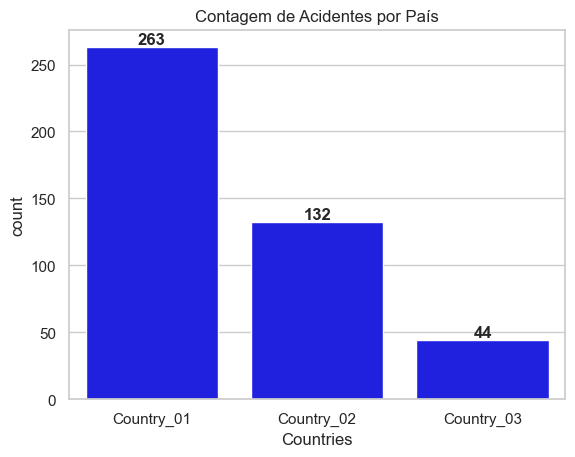

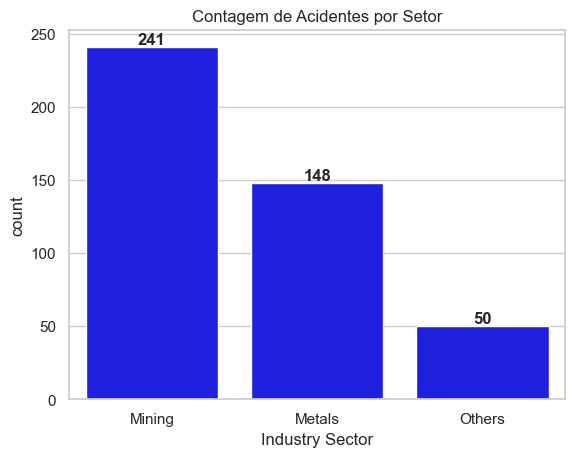

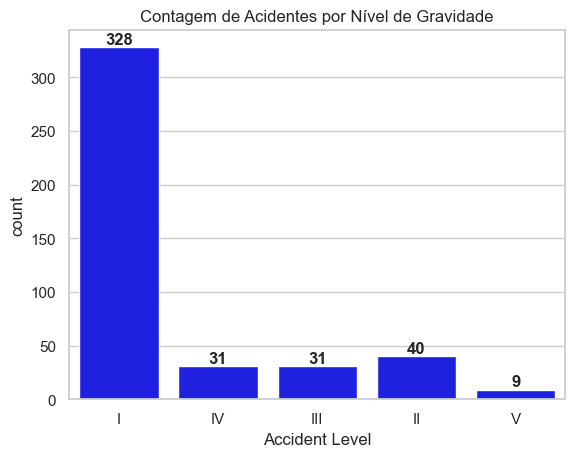

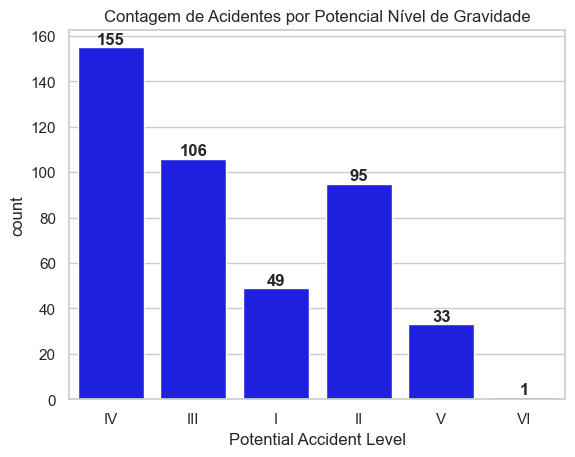

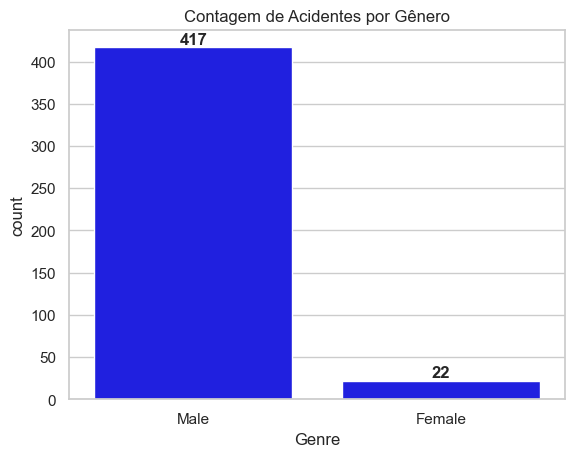

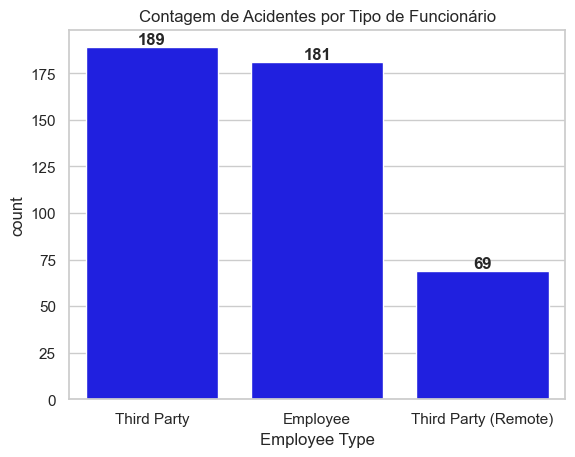

In [72]:
def plot_countplot(column, title, bar_color='blue'):
    """
    Gera um gráfico de barras com contagem (countplot) para uma coluna específica de um DataFrame.

    :param column: A coluna do DataFrame a ser usada no gráfico.
    :param title: O título do gráfico.
    :param bar_color: A cor das barras no gráfico (padrão é 'blue').

    Exemplo:
    >>> plot_countplot('Tipo de Acidente', 'Tipos de Acidentes', bar_color='green')
    
    Observações:
    - A função utiliza a biblioteca seaborn (sns) para gerar o gráfico.
    - A contagem de cada categoria é exibida nas barras.
    - O parâmetro 'bar_color' permite personalizar a cor das barras podendo usar códigos HTML ou Hexadecimais.
    """
    # Transformação para uma variavel "ax" para facilitar a manipulação.
    ax = sns.countplot(x=column, data=df, palette=[bar_color])
    # Loop for para a geração das diversas barras.
    for p in ax.patches:
        height = p.get_height()
        ax.annotate(f'{int(height)}', (p.get_x() + p.get_width() / 2., height),
                    ha='center', va='bottom', xytext=(0, 0), textcoords='offset points', weight='bold')
    plt.title(f'Contagem de Acidentes por {title}')
    plt.show()

# Uso da função na geração dos gráficos.
plot_countplot('Countries', 'País')
plot_countplot('Industry Sector', 'Setor')
plot_countplot('Accident Level', 'Nível de Gravidade')
plot_countplot('Potential Accident Level', 'Potencial Nível de Gravidade')
plot_countplot('Genre', 'Gênero')
plot_countplot('Employee Type', 'Tipo de Funcionário')

Como podemos analisar acima, a maior quantidade de acidentes estão relacionados ao **País 1 , com o setor de Mineração, sendo os acidentes com baixo nível de gravidade, porém com potêncial de gravidade alto, envolvendo maçicamente homens, e com distribuição igualitária entre funcionários próprios ou terceiros.**

Agora vamos analisar as categorias "Data", "Local" e "Critical Risk" de outra maneira, para podermos visualizar melhor quais elementos interferem mais no número de acidentes.

Como há muita discrepância entre os valores únicos de cada categoria, "Local" e "Critical Risk" serão analisados usando gráficos de contagem ordenada.

Enquanto lidaremos com a "Data" através de um gráfico temporal.

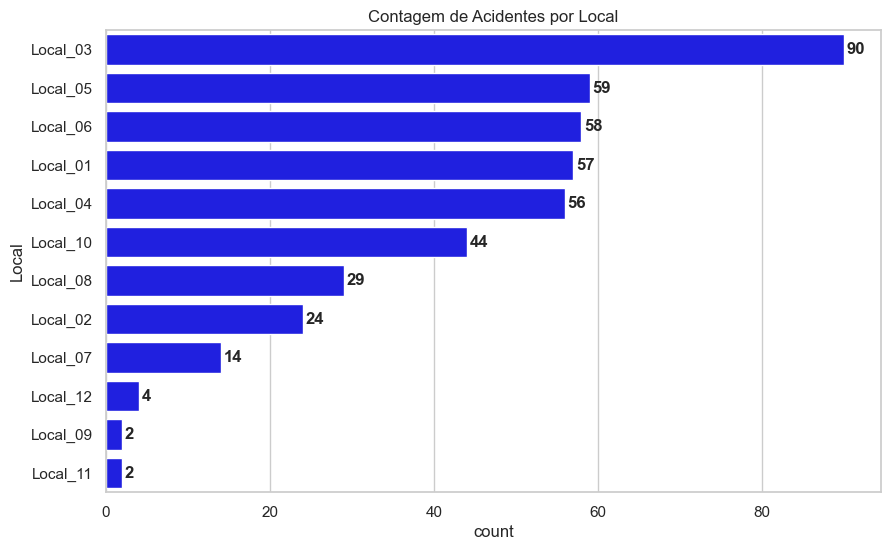

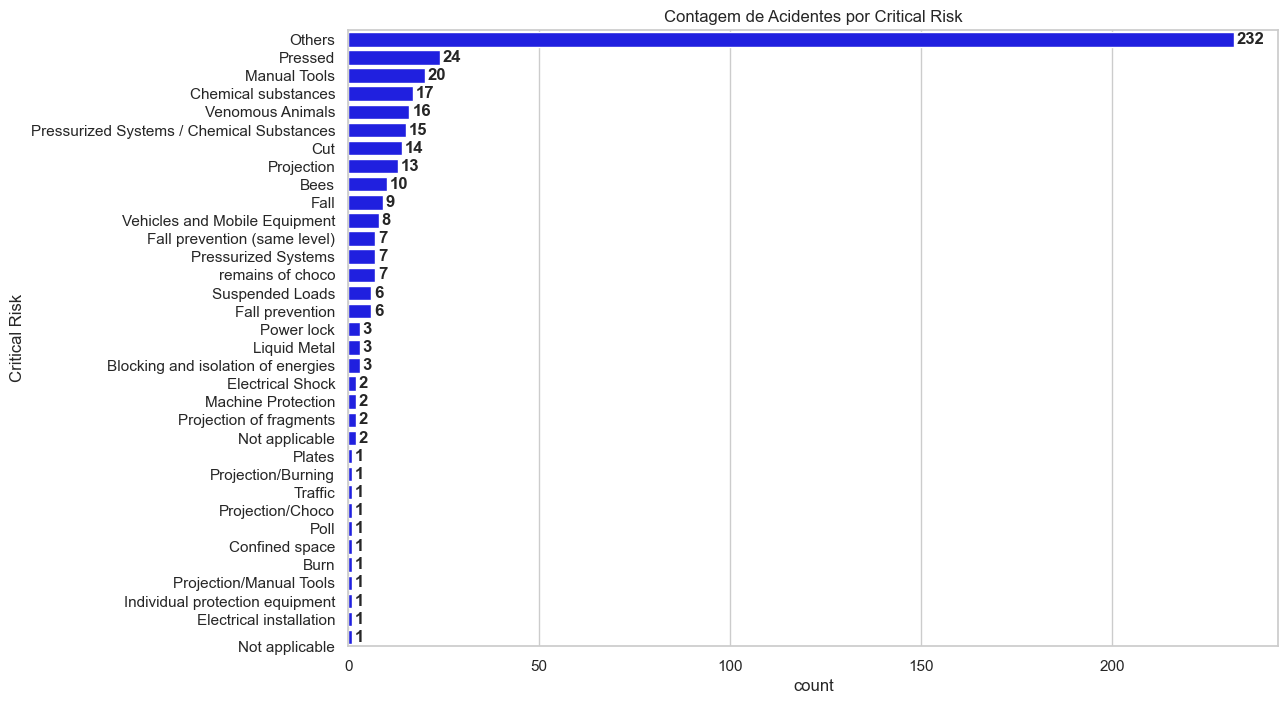

In [73]:
def plot_horizontal_countplot(df, column, figsize=(10, 6), bar_color='blue'):
    """
    Gera um gráfico de barras (countplot) ordenado para uma coluna específica de um DataFrame em exibição horizontal.

    :param df: O DataFrame que contém os dados.
    :param column: A coluna do DataFrame a ser usada no gráfico.
    :param figsize: As dimensões da figura do gráfico (padrão é (10, 6)).
    :param bar_color: A cor das barras no gráfico (padrão é 'blue').

    Exemplo:
    >>> plot_ordered_countplot(df, 'Tipo de Acidente', figsize=(12, 8), bar_color='green')

    Observações:
    - A função utiliza a biblioteca seaborn (sns) para gerar o gráfico.
    - O gráfico é apresentada com barras horizontais para colunas que contenham muitas categorias diferentes
    - A contagem de cada categoria é exibida ao lado das barras.
    """
    
    plt.figure(figsize=figsize)
    ax = sns.countplot(y=column, data=df, order=df[column].value_counts().index, orient='h', palette=[bar_color])
    
    for p in ax.patches:
        width = p.get_width()
        ax.annotate(f'{int(width)}', (width, p.get_y() + p.get_height() / 2.),
                    ha='left', va='center', xytext=(2, 0), textcoords='offset points', weight='bold')

    plt.title(f'Contagem de Acidentes por {column}')
    plt.show()
    
plot_horizontal_countplot(df, 'Local')
plot_horizontal_countplot(df, 'Critical Risk', figsize=(12, 8))

Podemos perceber agora que dentro das categorias "Local" e "Critical Risk", o **Local_03 e o risco crítico "Others" são os maiores responsáveis pela quantidade do número de acidentes.**

Porém há de se considerar que **Others** não nos diz uma informação concreta do que de fato causou o acidente, para termos uma análise mais convicente devemos distribuir de maneira ponderada os valores que constam dentro dessa categoria para as demais categorias para termos mais assertividade em nossa ánalise.

## 3.2 Redistribuição de dados não-identificados

Precisamos realizar a distribuição da variável "Others" dentro de "Critical Risk" pois é de suma importância para a criação de nosso modelo adiante.

A coluna "Industry Sector" também tem uma categoria "Others", porém esta não precisa de tratamento, pois se trata de uma categoria pouco impactante em nossa análise, e que contém somente 3 elementos com quantidades extremamente bem definidas entre elas.

**Portanto nosso objetivo agora será realizar o tratamento apenas da variável "Others" dentro da categoria "Critical Risk".**

In [74]:
df_critical_risk = df[['Critical Risk']].copy()
df_critical_risk.head(10)

,Critical Risk
0,Pressed
1,Pressurized Systems
2,Manual Tools
3,Others
4,Others
5,Pressurized Systems
6,Fall prevention (same level)
7,Pressed
8,Others
9,Chemical substances


### Substituindo valores "Others"

Para realizar a substituição dos valores de "Others", iremos criar uma função chamada `substitute_others`, que irá iterar sob um intervalo definido pelo usuário, na qual ele substiuirá os valores "Others" pelo valor mais frequente nesse intrevalo.
O que é extremamente importante para que as distorções sejam as menores possíveis em nossa análise.

In [75]:
def substitute_others(df, column, interval_size):
    """
    Substitui o valor 'Others' na coluna especificada por um dos dois valores mais frequentes em intervalos definidos.

    :param df: O DataFrame contendo os dados.
    :param column: A coluna na qual realizar a substituição do valor 'Others'.
    :param interval_size: O tamanho do intervalo para análise (número de linhas).

    :return: Um novo DataFrame com a substituição realizada.

    Exemplo:
    >>> df_resultado = substitute_others(df_original, 'Critical Risk', interval_size=5)

    Observações:
    - A função opera no DataFrame original, fazendo uma cópia antes de iniciar as modificações.
    - Substitui o valor 'Others' pelos dois valores mais frequentes dentro de cada intervalo.
    - Se não houver dois valores distintos no intervalo, o valor mais frequente do intervalo anterior é utilizado.
    """
    df_processed = df.copy()
    critical_risk_column = df_processed[column]
    prev_top_values = []
    
    # Iteração a cada intervalo escolhido.
    for i in range(0, len(critical_risk_column), interval_size):
        # Define os limites do intervalo.
        interval_end = min(i + interval_size, len(critical_risk_column))
        # Obtenção dos Elementos no intervalo, exceto "Others".
        interval_values = critical_risk_column[i:interval_end].loc[critical_risk_column[i:interval_end] != "Others"]
      
    # Verificação dos valores únicos no intervalo.
        if len(interval_values.unique()) >= 2:
            # Calculo dos dois valores de maior frequência no intervalo.
            top_values = interval_values.value_counts().nlargest(2).index.tolist()
            # Mudança do valor mais frequente no intervalo, subsituindo "Others".
            df_processed.loc[(critical_risk_column == "Others") & (df_processed.index >= i) & (df_processed.index < interval_end), "Critical Risk"] = top_values[0]
            # Atualização da lista de valores anteriores mais frequentes
            prev_top_values = top_values
        elif prev_top_values:
            # Caso não haja valores de frequência no intrevalo, pega o valor mais frequente no intervalo anterior.
            df_processed.loc[(critical_risk_column == "Others") & (df_processed.index >= i) & (df_processed.index < interval_end), "Critical Risk"] = prev_top_values[0]

    return df_processed

df_critical_risk_no_others = substitute_others(df_critical_risk, 'Critical Risk', interval_size=3)
df_critical_risk_no_others
del df_critical_risk

Como temos 439 valores, que é um número primo, não é possível dividir em partes iguais, portanto foi criada **uma condição para que a função realize a substituição do valor "Others" no último intervalo com os valores que restarem e forem menores que o tamanho escolhido.**

Para a nossa análise foi escolhido o tamanho de intervalo igual à 3, pois qualquer variação acima disso seria extremamente sensível, e poderia não se refletir na realidade.

Logo em seguida geramos o gráfico de barras por ordenação usando a função `plot_ordered_countplot` para verificar se de fato os valores de "Other" foram complemente subscritos, além de ter a informação dos Riscos Críticos de maneira mais realista e completa.

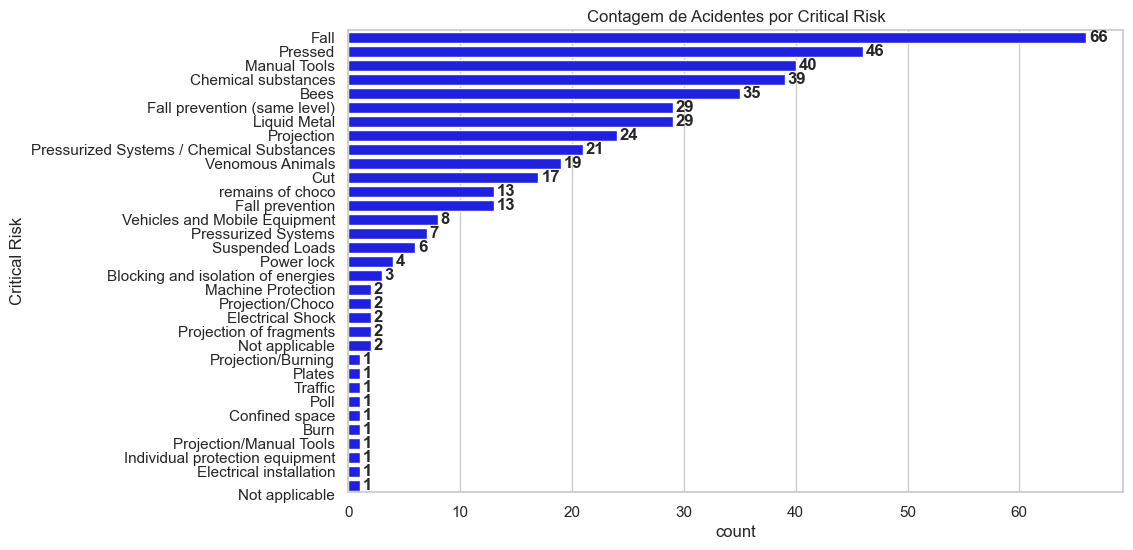

In [76]:
plot_horizontal_countplot(df_critical_risk_no_others, 'Critical Risk')

Com a geração do gráfico, nós podemos perceber os valores **"Fall"**, **"Pressed"**, **"Manual Tools"**, **"Chemical Substances"** e **"Bees"**, são os mais relevantes causadores de acidentes.

Feito isso, substituímos essa categoria corrigida no dataframe original, deletamos o dataframe temporário a fim de desocupar espaço em memória, e seguimos com nossas análises.

In [77]:
df['Critical Risk'] = df_critical_risk_no_others['Critical Risk'].copy()
del df_critical_risk_no_others
df.head()

,Data,Countries,Local,Industry Sector,Accident Level,Potential Accident Level,Genre,Employee Type,Critical Risk
0,2016-01-01,Country_01,Local_01,Mining,I,IV,Male,Third Party,Pressed
1,2016-01-02,Country_02,Local_02,Mining,I,IV,Male,Employee,Pressurized Systems
2,2016-01-06,Country_01,Local_03,Mining,I,III,Male,Third Party (Remote),Manual Tools
3,2016-01-08,Country_01,Local_04,Mining,I,I,Male,Third Party,Pressed
4,2016-01-10,Country_01,Local_04,Mining,IV,IV,Male,Third Party,Pressed


## 3.3 Análise Temporal das Datas por Número de Acidentes

Trataremos aqui separadamente da categoria "Data", pois se trata de uma variável temporal, e nosso objetivo é verificar os picos de acontecimento de acidentes juntamente com as demais variáveis.

Para fazermos isso iremos criar uma função que seja capaz de criar e exibir esse gráfico automaticamente, juntamente com o número de acontecimento em cada período, seja mensal, trimestral ou semestral.

A nossa análise, não irá considerar a anualização dos dados, pois o período de acontecimento de acidentes é insuficiente para podermos fazer qualquer análise mais aprofundada.

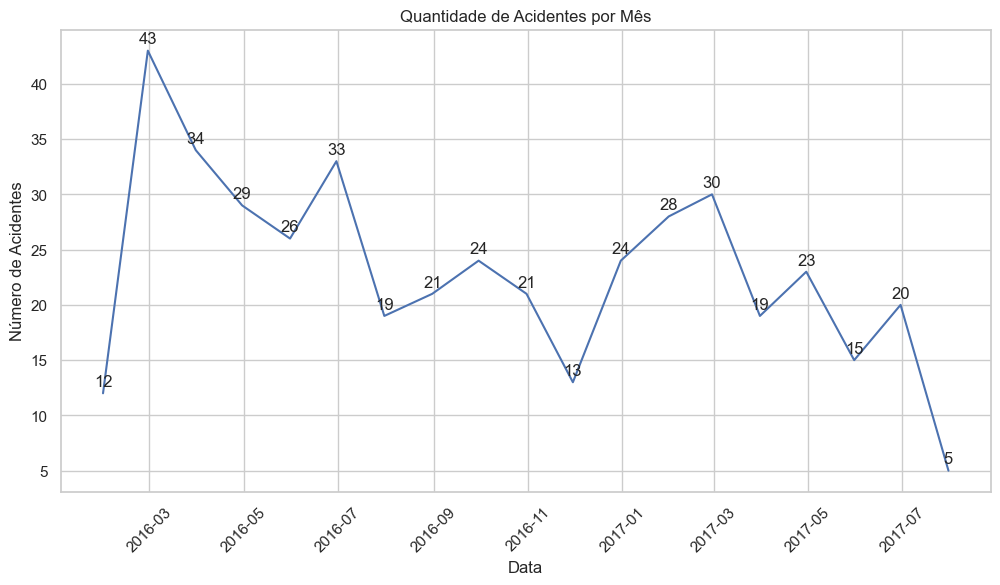

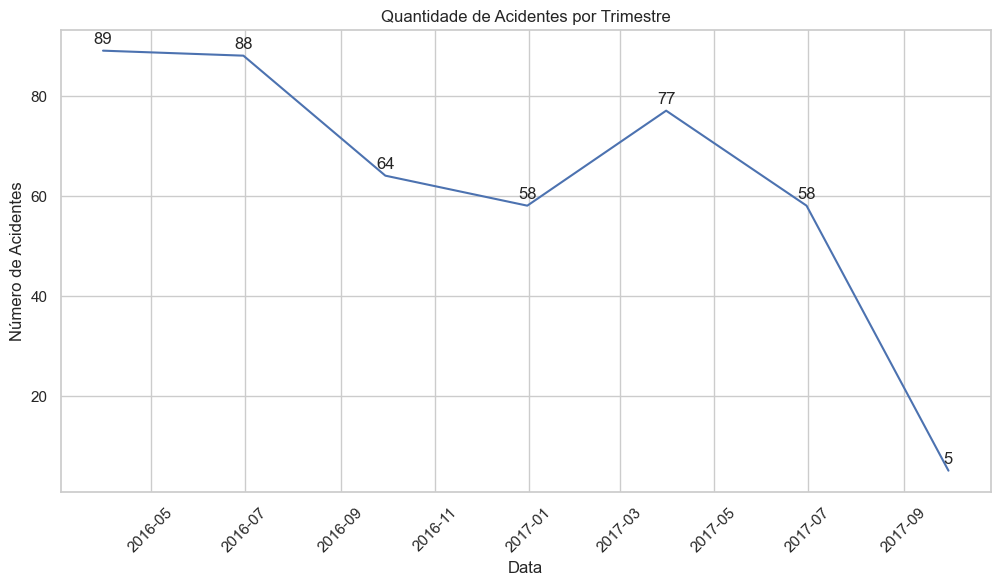

In [78]:
def plot_trend_accident(dataframe, period, title):
    """
    Gera um gráfico de tendência de acidentes ao longo do tempo.

    :param dataframe: O DataFrame contendo os dados.
    :param period: O período de resample para agrupar os dados temporalmente 
    ('D' para dia, 'M' para mês, 'Q' para trimestre, 
    'S' para semestre, 'A' para ano).
    :param title: O título do gráfico.

    Exemplo:
    >>> plot_trend_accident(df_dados, 'M', 'Tendência Mensal de Acidentes')

    Observações:
    - A função converte a coluna 'Data' para o tipo datetime.
    - Realiza um resample dos dados para o período especificado, contando o número de acidentes em cada intervalo.
    - Utiliza a biblioteca seaborn (sns) para criar um gráfico de linha temporal.
    - Adiciona rótulos com o número de acidentes em cada ponto do gráfico.
    """
    
    df = dataframe.copy()
    df['Data'] = pd.to_datetime(df['Data'])

    # Agrupamento e contagem do número de acidentes escolhido pelo usuário.
    df_count = df.resample(period, on='Data').size().reset_index(name='Accident Count')

    # Cria o gráfico de linha temporal usando o Seaborn.
    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12, 6))
    sns.lineplot(x='Data', y='Accident Count', data=df_count, errorbar=None)
    
    # Adição dos números de acidentes em cada ponto.
    for index, row in df_count.iterrows():
        plt.annotate(f'{row["Accident Count"]}', 
                     (row['Data'], row['Accident Count']),
                     textcoords="offset points",
                     xytext=(0,5),
                     ha='center')
    plt.title(title)
    plt.xlabel('Data')
    plt.ylabel('Número de Acidentes')
    plt.xticks(rotation=45)
    plt.show()

    
plot_trend_accident(df, 'M', 'Quantidade de Acidentes por Mês')
plot_trend_accident(df, 'Q', 'Quantidade de Acidentes por Trimestre')

É possível pereceber que a maior ocorrência de aidentes, se deu no **Segundo trimestre de 2016**, e também houve um segundo pico no número de acidentes no **Segundo trimestre de 2017**, com um maior número de ocorrências no mês de **Março**, tanto em 2016, quanto 2017.

Porém a longo prazo é possível visualizar uma tendência de queda, no número de acidentes.

Apesar de ainda não ser possível determinar a causa raíz desses acidentes, e o motivo de seu acontecimento, podemos propor que durante esse período sejam feitos eventos de conscientização sobre os acidentes, e assim podermos diminuir os seus acontecimentos nessas épocas.

## 3.4 Análise dos Elementos Categóricos e Associações

Após o tratamento dos Elementos Categóricos, estamos prontos para realizar análises mais profundas nos dados.

As análises que iremos fazer serão as seguintes:

* **Análise de Associação com _Heatmap_**

Avaliação da Correlação entre os números de acidentes com entre duas categorias.

* **Análise de Qui-Quadrado**

Análise para encontro de correlações não-caóticas entre as variáveis, de modo a encontrar a correlação das variáveis que mais causam acidentes.





In [79]:
df.describe(datetime_is_numeric=True)

,Data
count,439
mean,2016-09-14 14:03:00.410022656
min,2016-01-01 00:00:00
25%,2016-04-22 00:00:00
50%,2016-09-03 00:00:00
75%,2017-02-04 12:00:00
max,2017-07-09 00:00:00


Podemos observar acima, que a data com mais frequência de acidentes é **26/02/2016**, com 13 acidentes registrados somente neste dia, também podemos afirmar que aconteceram acidentes em 287 dias diferentes.
Quanto ao país, **Country_01** foi o país com mais ocorrência de acidentes com 263 ocorrências, também podemos afirmar que o setor de **Mineração** é o mais perigoso com 241 acidentes.

Quanto à gravidade dos acidentes, é possível afirmar que dentre os 439 acidentes, 328  foram de **Grau 1**, ou seja, acidentes leves, o que representa **74,15%** do total de acidentes, um número que representa quase três quartos dos acidentes.
Porém o potencial de dano de 155 dos 439 acidentes registrados foi de **Grau IV**, e poderiam ter sido mais graves do que realmente foram, observamos também a quantidade massiva de **Homens** envolvidos nestes acidentes, e também os dados nos mostram que **Funcionários Terceiros** são as maiores vitimas dos acidentes.

Por fim o maior fator critíco para acontecer os acidentes foi em 66 dos 439 acidentes registrados, o **Risco de Quedas**, podemos perecber que o fator crítico é uma categoria extremamente distribuída, portanto não é possível afirmar que esta é uma categoria extremamente determinante para a gravidade um acidente.


### Análise Correlacional das Categorias

Para poder ser capaz de criar um modelo preciso, é necessário que analisemos as correlações fortes e fracas entre cada categoria.

Para realizar essa correlação nós utilizamos o **Coeficiente de Kendall**, que é a técnica mais indicada nesse para esta situação, visto que estamos lidando com dados categóricos e não numéricos, que é o principal foco da **Análise de Pearson**.

Nesta análise os valores variam de 1 até -1, sendo 1 significa uma correlação positiva perfeita, isto é, uma categoria está fortemente relacionada com a outra em se tratando de acidentes, de maneira lógica, o que acontece é que se a Categoria A acontece, então Categoria B também acontece.
Enquanto -1 está com uma  correlação negativa perfeita, ou seja, uma categoria de acidentes está correlacionada com a outra porém de maneira inversa, isto é, se a Categoria A acontece, então Categoria B não.

Porém como os dados são categóricos e não numéricos, é necessário realizar uma conversão para que nós possamos realizar o gráfico de _Heatmap_.

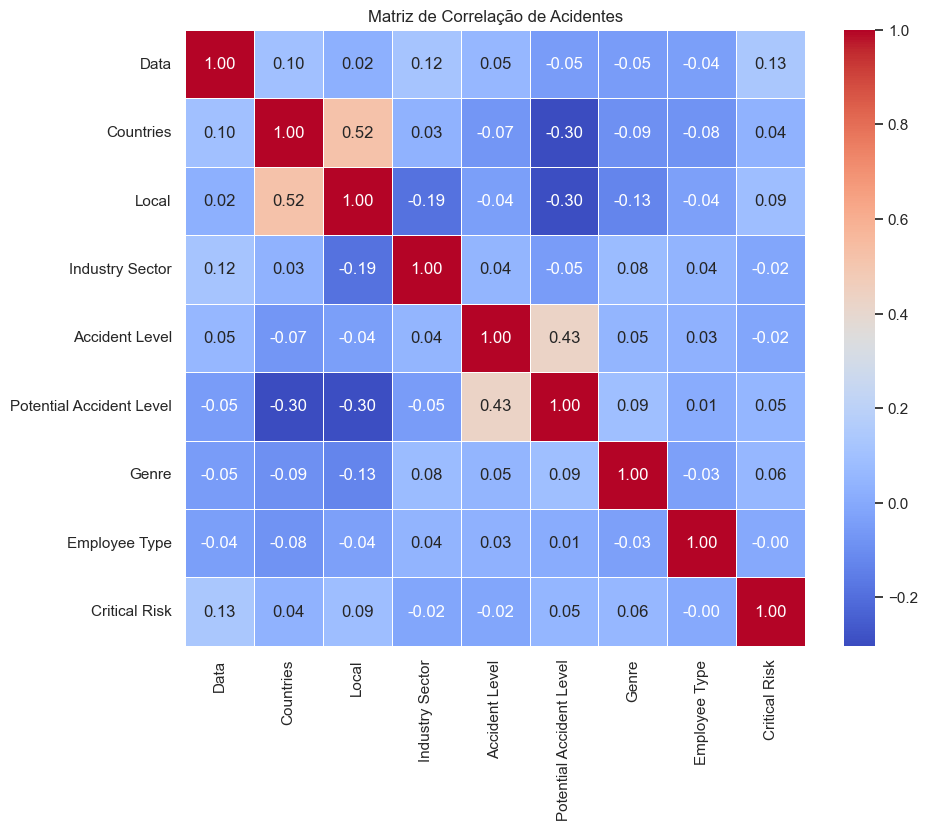

In [80]:
# Conversão dos dados categóricos para tipos numéricos para facilitar a geração do gráfico.
df_numbers = df.apply(lambda x: x.astype('category').cat.codes)

# Calculo da Matriz de Correlação pelo Método de Kendall
corr_matrix = df_numbers.corr(method='kendall')

# Geração do heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title('Matriz de Correlação de Acidentes')
plt.show()

Como podemos ver, as categorias com forte correlação positiva são **Countries** e **Local**, **Accident Level** e **Potential Accident Level**, logo devemos análisar com mais cuidado a relação entre essas categorias.

Também podemos citar com correlação negativa as variáveis **Local** e **Potential Accident Level**, e também a relação entre as variáveis **Countries** e **Potential Accident Level**, que é possível afirmar que o acontecimrnto de um, pode refletir de certa maneira, com o aparecimento do outro.

Para garantir essas condições como verdadeiras precisamos fazer essa verificação de correlação usando outros métodos como a **Análise do Qui-Quadrado**.

### Análise de Qui-Quadrado entre as Categorias

Após verificarmos as correlações entre as categorias **Countries, Local, Accident Level e Potential Accident Level**, precisamos realizar validações se as correlações realmente são existentes e não apenas caóticas, e surgiram apenas nesta amostra.

Para realizar essa análise, além de escolhermos as categorias que mais farão sentido, é importante também selecionarmos o **alpha** apropriado para nossa amostra, que deve ser 0.05 ou 0.01, caso se deseje ser mais rigoroso, porém aumentando a chance de não rejeitar a hipótese, mesmo que ela se demonstre falsa (Erro Tipo II).

Para a nossa análise, o nosso objetivo é minimizar a rejeição das hipóteses nulas verdadeiras (Erro Tipo I), o que faz sentido visto que queremos minimizar a quantidade de acidentes, portanto é sensato que todas as correlações que possam causar mais acidentes de trabalho sejam capturadas e analisadas pelo algoritmo, portanto iremos manter o valor padrão de **alpha = 0.05**.



In [81]:
def chi_squared_test(df, col1, col2, alpha=0.05):
    """
    Realiza o teste de Qui-Quadrado para a independência entre duas variáveis categóricas.

    Parâmetros:
    - dataframe: DataFrame contendo os dados categóricos.
    - col1: Nome da primeira coluna para comparação.
    - col2: Nome da segunda coluna para comparação.
    - alpha: Nível de significância a depender da análise, deve ser 0.05(default) ou 0.01

    Retorna:
    - Análise prévia dos resultados conforme valor de alpha.
    - chi2: medição de força de associação entre as variaveis.
    - p: medição de significância na associação entre as variaveis. 
    """
    # Tabela de Contingência
    contingency_table = pd.crosstab(df[col1], df[col2])

    # Aplicção do Teste de Hipótese Qui-Quadrado
    chi2, p, _, _ = chi2_contingency(contingency_table)
    print(f"Chi-Square Value: {chi2}")
    print(f"P-Value: {p}")

    # Análise prévia dos resultados
    print("\nResultado do Teste:")
    if p < alpha:
        print("Rejeita a hipótese nula. As variáveis são dependentes.")
    else:
        print("Falha em rejeitar a hipótese nula. As variáveis são independentes.")
        
    return chi2, p


In [82]:
print('Teste do Qui-Quadrado entre Accident Level e Potential Accident Level\n')
chi_squared_test(df, 'Accident Level', 'Potential Accident Level')

print(100*'-')

print('\nTeste do Qui-Quadrado entre Countries e Local\n')
chi_squared_test(df, 'Countries', 'Local')

print(100*'-')

print('\nTeste do Qui-Quadrado entre Countries e Potential Accident Level\n')
chi_squared_test(df, 'Countries', 'Potential Accident Level')

print(100*'-')

print('\nTeste do Qui-Quadrado entre Countries e Accident Level\n')
chi_squared_test(df, 'Countries', 'Accident Level')


Teste do Qui-Quadrado entre Accident Level e Potential Accident Level

Chi-Square Value: 251.17651773496243
P-Value: 6.614582414271079e-42

Resultado do Teste:
Rejeita a hipótese nula. As variáveis são dependentes.
----------------------------------------------------------------------------------------------------

Teste do Qui-Quadrado entre Countries e Local

Chi-Square Value: 878.0
P-Value: 1.6580146239373698e-171

Resultado do Teste:
Rejeita a hipótese nula. As variáveis são dependentes.
----------------------------------------------------------------------------------------------------

Teste do Qui-Quadrado entre Countries e Potential Accident Level

Chi-Square Value: 204.2532229742374
P-Value: 2.0916839950576648e-38

Resultado do Teste:
Rejeita a hipótese nula. As variáveis são dependentes.
----------------------------------------------------------------------------------------------------

Teste do Qui-Quadrado entre Countries e Accident Level

Chi-Square Value: 13.471722439883

(13.471722439883884, 0.09661704935193592)

Como os resultados mostram, apenas as categorias **Countries** e **Accident Level**, de acordo com os dados que temos, é possível concluir que são duas categorias que não interferem uma com a outra, na causa dos acidentes.
Portanto um determinado país, não está relacionado diretamente com a gravidade do acidente.

## 4. Criação de Modelo de Previsão com _Machine Learning_

Existem diversos tipos de algoritmos que podem ser capazes de gerarem modelos de _Machine Learning_ para o nosso problema com Dados Categóricos, e nós iremos nos beneficiar no uso de algum deles, de forma a termos o modelo mais otimizado possível, mas que não sofra de _Overfitting_ e tão pouco _Underfitting_, visto que é importante a generalização de nosso modelo, e que possa ter uma boa taxa de acerta nas previsões.

Os nossos modelos buscarão à responder a seguinte asserção:

**Fazer previsões de se acontecerá um acidente de trabalho com base nas informações de País, Local, Setor da Empresa, Gênero e Risco Critico, e caso o acidente aconteça qual o nível de gravidade do mesmo.**

## 4.1 Modelo de _Random Forest_


Inicialmente iremos criar o primeiro modelo usando o algoritmo de **Random Forest**, que nada mais é do que a geração de diversas **Árvores de Decisão** individuais, e fazendo parte dos algoritmos **Ensambled**, seu resultado depende da combianção dessas várias árvores de decisão individuais para obter as previsões mais acuradas possíveis.

Primeiramente para poder ter uma boa visualização da Matriz de Confusão vamos criar uma função que mostra uma exibição mais gráfica, e na qual seja possível realizar a normalização da matriz para verificarmos os dados de maneira absoluta e não apenas quantitativo.

In [83]:
def plot_confusion_matrix(y_true, y_pred, classes, normalize=False, title=None, cmap='Blues'):
    """
    Gera um gráfico de matriz de confusão para avaliação de modelos de classificação.

    :param y_true: As verdadeiras classes alvo.
    :param y_pred: As classes preditas pelo modelo.
    :param classes: Uma lista das classes possíveis, que são as categorias em comparação.
    :param normalize: Se True, a matriz de confusão será normalizada (variação entre -1 a 1).
    :param title: O título do gráfico (padrão é 'Matriz de Confusão').
    :param cmap: O esquema de cores a ser utilizado no gráfico (padrão é 'Blues').

    Exemplo:
    >>> plot_confusion_matrix(y_true, y_pred, ['Classe A', 'Classe B', 'Classe C'], normalize=True)

    Observações:
    - A função utiliza a biblioteca seaborn (sns) para criar um mapa de calor da matriz de confusão.
    - As classes são formatadas em LATEX para uma aparência mais destacada.
    """
    cm = confusion_matrix(y_true, y_pred)
    
    # Condicional de normalização da matriz de confusão
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
     
    # Formatação LATEX para as legendas dos eixos
    classes_latex = [r'$\bf{' + cls + '}$' for cls in classes]
    
    plt.figure(figsize=(4, 3))
    sns.heatmap(cm, annot=True, fmt='.2f' if normalize else 'd', cmap=cmap, cbar=False,
                xticklabels=classes_latex, yticklabels=classes_latex)
    
    plt.xlabel('Predicted Label')
    plt.ylabel('Real Label')
    plt.title(title if title else 'Matriz de Confusão')
    plt.show()
    

Feito a função para a geração do _Heatmap_, o objetivo a seguir é a criação do modelo de _Machine Learning_, que irá fazer as previsões, é importante avisar, que como estamos utilizando dados categóricos e muito dos modelos de ML, usam para suas previsões dados numéricos é necessário que nós façamos uma codificação adequada, para que o modelo seja capaz de ler os dados, o que será feito com a classe **LabelEncoder()**

O Próximo passo é realizar a divisão entre dados de teste e dados de treinamento. A proporção escolhida foi de 50% para cada um deles, a proporção foi feita dessa forma, pois nessa primeira iteração, ainda não foi utilizada a técnica de **Validação Cruzada**, portanto como nossa base de dados é extremamente enxuta, precisamos otimizar os dados de treinamento da melhor forma possível.

Accuracy: 0.69


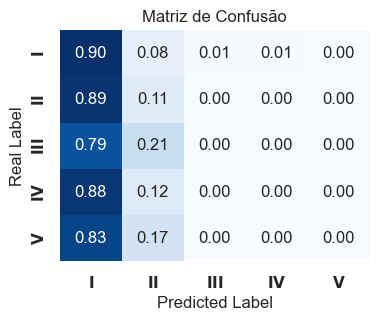


Relatório de Classificação:
              precision    recall  f1-score   support

           I       0.76      0.90      0.83       165
          II       0.09      0.11      0.10        18
         III       0.00      0.00      0.00        14
          IV       0.00      0.00      0.00        17
           V       1.00      0.00      0.00         6

    accuracy                           0.69       220
   macro avg       0.37      0.20      0.19       220
weighted avg       0.60      0.69      0.63       220



In [84]:
# Separando as variaveis dependentes (X) e independentes (y)
X = df.drop(['Data', 'Accident Level', 'Potential Accident Level'], axis=1)
y = df['Accident Level']

# Convertendo variáveis categóricas para numéricas
le = LabelEncoder()
X = X.apply(le.fit_transform)

# Dividindo os dados em conjuntos de treinamento e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.5, random_state=42)

# Criando o modelo de Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Treinando o modelo
rf_model.fit(X_train, y_train)

# Fazendo previsões no conjunto de teste
y_pred = rf_model.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy:.2f}')

# Exibindo a matriz de confusão e o relatório de classificação
classes = ['I', 'II', 'III', 'IV', 'V']
plot_confusion_matrix(y_test, y_pred, classes, normalize=True)

class_report = classification_report(y_test, y_pred, zero_division=1)
print("\nRelatório de Classificação:")
print(class_report)

Após a criação do modelo de Random Forest para o problema, foi possível perceber que houve uma taxa de acerto de 69%, o que é pode ser considerada uma boa taxa de acerto, porém percebemos que o modelo tem uma forte tendência de prever com mais probabilidade acidentes de **Grau I**, provavelmente por ter **165** elementos desta categoria, em detrimento dos demais graus de acidentes com maior gravidade, que seriam desejados ter uma previsão mais precisa, portanto iremos adicionar um peso às categorias com menos frequência para que o modelo se torne equalizado com as previsões do mundo real.

Como não é possível alterar a base de dados, e já fizemos todo o processo de **ETL**, a nossa próxima alternativa é realizar o estudo e desenvolvimento de um novo modelo de _Machine Learning_ com outros tipos de algoritmos, ou então podemos esgotar o modelo até o seu pico de desempenho, aplicando o _Fine Tuning_, que nada mais é do que a expoloração do modelo, com o objetivo de otimiza-lo ainda mais.

Para realizar o _Fine Tuning_ devemos modificar os hiperparâmetros da instância do **RandomForestClassifier** que nós criamos para o modelo.

Para fazer de uma forma mais automatizada, e não ter que realizar o teste manualmente, usaremos o algoritmo de _Random Search_, que realiza a pesquisa aleatória dos hiperparâmetros mais relevantes para o nosso modelo ao invés de todas as possíveis combinações.

Junto a isso utilizaremos também o modelo de **Validação Cruzada** para a avaliação dos diversos conjuntos de treinamento e teste, garantindo que não haja o _overfitting_, e como consequência disso, haja uma maior generalização dos resultados.

Melhores Hiperparâmetros:
{'max_depth': 16, 'min_samples_leaf': 1, 'min_samples_split': 3, 'n_estimators': 102}
Taxa de Acerto após ajuste: 0.61


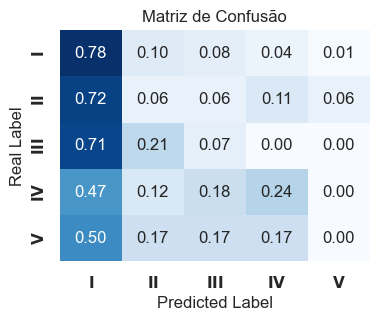


Relatório de Classificação após ajuste:
              precision    recall  f1-score   support

           I       0.79      0.78      0.78       165
          II       0.04      0.06      0.05        18
         III       0.05      0.07      0.06        14
          IV       0.29      0.24      0.26        17
           V       0.00      0.00      0.00         6

    accuracy                           0.61       220
   macro avg       0.23      0.23      0.23       220
weighted avg       0.62      0.61      0.61       220



In [85]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    # Definir a grade de hiperparâmetros para pesquisa aleatória com granularidade de valores para melhor otimização.
    param_grid = {
    'n_estimators': randint(50, 151),  # Intervalo de 50 a 150 (incluso)
    'max_depth': [None] + list(range(10, 31)),  # None e intervalo de 10 a 30
    'min_samples_split': randint(2, 11),  # Intervalo de 2 a 10 (incluso)
    'min_samples_leaf': randint(1, 5)  # Intervalo de 1 a 4 (incluso)
    }

    rf_model_weight = RandomForestClassifier(class_weight='balanced', random_state=42)
    random_search = RandomizedSearchCV(estimator=rf_model_weight, param_distributions=param_grid, n_iter=150, scoring='accuracy', cv=5, random_state=42)
    random_search.fit(X_train, y_train)

print("Melhores Hiperparâmetros:")
print(random_search.best_params_)

# Avaliação do modelo
y_pred_tuned = random_search.predict(X_test)
accuracy_tuned = accuracy_score(y_test, y_pred_tuned)
print(f'Taxa de Acerto após ajuste: {accuracy_tuned:.2f}')

plot_confusion_matrix(y_test, y_pred_tuned, classes, normalize=True)

class_report_tuned = classification_report(y_test, y_pred_tuned, zero_division=1)
print("\nRelatório de Classificação após ajuste:")
print(class_report_tuned)

Podemos observar que mesmo após essa primeira rodada de ajuste, ainda não foi satisfatório, pois nosso banco de dados está fortemente desbalanceado pela classe **I**, e como consequência, não é capaz de prever os acidentes de maior intensidade com maior acurácia individual, como podemos ver na métrica **f1-score**.

Portanto para esta segunda rodada de ajuste, nosso foco será em extrair o máximo de performance do algoritmo de **Random Forest**, antes que possamos migrar para um próximo modelo.

O que pode ser feito é realizar a modificação dos pesos das categorias com menos recorrência para que o modelo posso ter uma maior probabilidade de identifica-las corretamente, ou seja, nesse caso o nosso foco é minimizar a ocorrência de **Falsos Negativos** , que são a não identificação de um determinado nível de um acidente para um nível mais baixo, do que ele de fato aconteceu.

Para auxiliar com este trabalho, será necessário o uso de uma biblioteca que seja capaz de lidar diretamente com os pesos das categorias com maior versatilidade, portanto usaremos a biblioteca `imbalanced-learn`.

No código abaixo, foi colocado um bloco apara capturar possíveis mensagens de aviso, que possam atrapalhar a visualização da saída do modelo.

Accuracy: 0.19


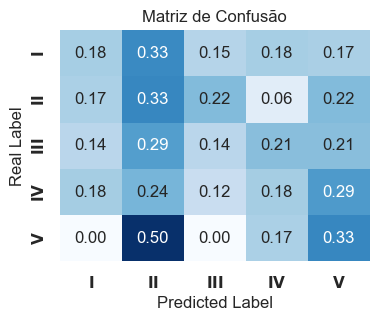


Relatório de Classificação:
              precision    recall  f1-score   support

           I       0.78      0.18      0.29       165
          II       0.08      0.33      0.13        18
         III       0.06      0.14      0.09        14
          IV       0.08      0.18      0.11        17
           V       0.05      0.33      0.08         6

    accuracy                           0.19       220
   macro avg       0.21      0.23      0.14       220
weighted avg       0.61      0.19      0.24       220



In [86]:
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    
    brf_model = BalancedRandomForestClassifier(max_features='auto', n_estimators=150, random_state=42, bootstrap=False, 
                                              sampling_strategy='auto', replacement=True)
    brf_model.fit(X_train, y_train)
   
    y_pred_brf = brf_model.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_brf)
print(f'Accuracy: {accuracy:.2f}')

# Exibindo a matriz de confusão e o relatório de classificação
plot_confusion_matrix(y_test, y_pred_brf, classes, normalize=True)

class_report = classification_report(y_test, y_pred_brf, zero_division=1)
print("\nRelatório de Classificação:")
print(class_report)

Como é possível pereceber o modelo gerou respostas mais distribuídas como vemos com a métrica do **f1-score**, o que é desejado pois é preferível que o modelo erre ao considerar um acidente mais grave do que realmente é ( Foi previsto **IV** porém o acidente foi de nível **II** do que ao contrário.

O modelo mesmo utilizando a classe `BalancedRandomForestClassifier` que tem o intuito de realizar o balanceamento dos dados de forma que não haja um grande descompasso, é possível notar a presença de muitos erros de previsão, o que torna esse modelo ineficaz para esse projeto, portanto devemos buscar um modelo que seja capaz de suprir a demanda e prever um acidente corretamente para que possamos tomar uma atitude corretiva para evitarmos esses acidentes.

## 4.2 Modelo de _Naive-Bayes_

O algoritmo que usaremos para a geração do próximo modelo é o algoritmo de **Naive-Bayes**, que também é um algoritmo de classificação, porém diferente do _Random Forest_ ele desconsidera totalmente as correlações entre as categorias, ou seja, para este caso ele irá identificar o acidente apenas por uma única descrição, que é o Nível de Gravidade, não importando as demais correlações de país, ou local.

Para este modelo, também adicionamos a **Validação Cruzada** desde o princípio, para podermos fazer o treinamento do modelo mais vezes, antes que ele possa ser de fato posto à prova, além de ser capaz de otimizar o pequeno banco de dados que nós temos para esse modelo, já que irão existir várias divisões entre dados de teste e de treinamento.

Accuracy: 0.22


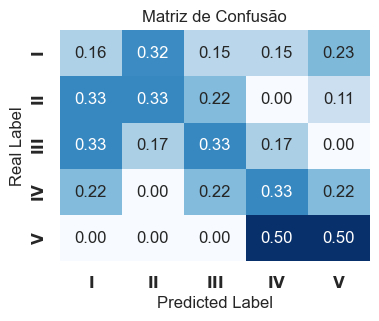


Relatório de Classificação:
              precision    recall  f1-score   support

           I       0.59      0.16      0.25        62
          II       0.12      0.33      0.18         9
         III       0.13      0.33      0.19         6
          IV       0.21      0.33      0.26         9
           V       0.06      0.50      0.10         2

    accuracy                           0.22        88
   macro avg       0.22      0.33      0.20        88
weighted avg       0.46      0.22      0.24        88

F1-Score médio na validação cruzada: 0.05
Desvio padrão dos F1-Scores: 0.03


In [87]:
# Separando as variaveis dependentes (X) e independentes (y)
X = df.drop(['Data', 'Accident Level', 'Potential Accident Level'], axis=1)
y = df['Accident Level']

# Convertendo variáveis categóricas para numéricas
le = LabelEncoder()
X = X.apply(le.fit_transform)

# Divisão entre treinamento e teste 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Criação de Modelo Naive-Bayes
nb_model = GaussianNB()

# Validação cruzada
cross_val_scores = cross_val_score(nb_model, X, y, cv=5, scoring='f1_macro')

nb_model.fit(X_train, y_train)

# Previsões do Modelo
y_pred_nb = brf_model.predict(X_test)

# Avaliando o desempenho do modelo
accuracy = accuracy_score(y_test, y_pred_nb)
print(f'Accuracy: {accuracy:.2f}')

# Exibindo a matriz de confusão e o relatório de classificação
plot_confusion_matrix(y_test, y_pred_nb, classes, normalize=True)

class_report = classification_report(y_test, y_pred_nb, zero_division=1)
print("\nRelatório de Classificação:")
print(class_report)
print(f'F1-Score médio na validação cruzada: {cross_val_scores.mean():.2f}')
print(f'Desvio padrão dos F1-Scores: {cross_val_scores.std():.2f}')

Os dados gerados pelo modelo, podem ser considerados como satisfatórios, pois é possível perceber uma boa generalização do modelo, ao mesmo tempo em que existe uma boa taxa de acerto no nível de acidentes bem próximos do que deveria ter sido previsto, por exemplo:

**O modelo dividiu suas previsões com 33% para o nível I (Incorreto), 33% para o nível II (Correto) e os demais 33% se dividindo entre nível III e nível V (menor proporção), o que é um comportamento generalista e com uma boa taxa de acerto.**

Outro ponto importante é a previsão dos acidntes de nível V, que teve uma extrema acurácia, e o modelo for capaz de acertar em **50%** das vezes, e mesmo quando fazia uma previsão incorreta, o modelo previa coomo um acidente de nível IV, o que é aceitável, visto que são categorias ordinais com alto grau de proximidade.

O contraponto vêm por conta da fraca previsão dos acidentes de nível I, que originalmente são os mais frequentes no banco de dados usado para a geração do modelo, essa situação é um _trade_off_ entre a acurácia de se prever a categoria com mais recorrência, porém com menos impacto (acidentes de trabalho com baixo impacto), e a capacidade de previsão de acidentes de maior gravidade com mais assertividade.

## 5. Deploy do Modelo 

Após a criação do modelo, é essencial que ele seja facilmente compartilhável em diversas plataformas, permitindo sua reutilização em novos treinamentos, testes e produção.

Para realizar a persistência desse modelo, optaremos pelo uso do módulo `pickle`, integrado nativamente ao Python. Essa escolha se destaca pela elevada compatibilidade com qualquer tipo de arquivo gerado pela linguagem, assegurando uma abordagem versátil e eficiente.

In [88]:
# Deploy do modelo
with open('LevelAccidents.pkl', 'wb') as f:
    pickle.dump(nb_model, f)
# Carregamento do modelo    
with open('LevelAccidents.pkl', 'rb') as f:
    pickle.load(f)

In [89]:
val_uni = {}

for column in df.columns:
    val_uni[column] = df[column].unique().tolist()
    
countries_uni = val_uni['Countries']
local_uni = val_uni['Local']
industry_sector_uni = val_uni['Industry Sector']
genre_uni = val_uni['Genre']
employee_type_uni = val_uni['Employee Type']
critical_risk_uni = val_uni['Critical Risk']

### Função que irá realizar o Deploy

Para facilitar ainda mais o deploy, criaremos uma função apenas para isso, de tal forma que o usuário entre com os dados, seja então feito o desempacotamento e a execução do modelo, de acordo com os parâmetros de entrada, retornando então a previsão do Grau de Acidente.

In [90]:
def predicator_work_accidents(country, local, industry_sector, genre, type_employee, critical_risk):
    """
    Realiza a previsão de acidentes de trabalho com base em características específicas.

    :param country: O país onde ocorre o trabalho.
    :param local: A localização específica do trabalho.
    :param industry_sector: O setor industrial associado ao trabalho.
    :param genre: O gênero do trabalhador.
    :param type_employee: O tipo de empregado (por exemplo, contratado, terceirizado).
    :param critical_risk: O risco crítico associado ao trabalho.

    :return: A previsão de acidente de trabalho e de seu grau de gravidade.

    Exemplo:
    >>> resultado_previsao = predicator_work_accidents('Brazil', 'Factory', 'Manufacturing', 'Male', 'Contracted', 'Chemical Exposure')

    Observações:
    - A função utiliza um modelo pré-treinado armazenado no arquivo 'LevelAccidents.pkl'.
    - Os parâmetros são utilizados para criar um DataFrame com os dados de entrada.
    - Os dados são codificados usando LabelEncoder antes de realizar a previsão.
    """
    
    dados0 = {'Countries': [country], 'Local': [local], 'Industry Sector': [industry_sector], 'Genre': [genre], 
             'Employee Type': [type_employee], 'Critical Risk': [critical_risk]}
    
    dados = pd.DataFrame(dados0)

    with warnings.catch_warnings():
        warnings.simplefilter("ignore")
    
        with open('LevelAccidents.pkl', 'rb') as f:
            model = pickle.load(f)

     # Criar uma cópia dos dados para codificar
    dados_encoded = dados.copy()

    # Aplicar LabelEncoder para cada coluna categórica
    label_encoder = LabelEncoder()
    for col in ['Countries', 'Local', 'Industry Sector', 'Genre', 'Employee Type', 'Critical Risk']:
        dados_encoded[col] = label_encoder.fit_transform(dados[col])

    # Fazer a previsão com os dados codificados
    pred = model.predict(dados_encoded)
    
    print(f'\nCountry: {country}')
    print(f'Local: {local}')
    print(f'Industry Sector: {industry_sector}')
    print(f'Genre: {genre}')
    print(f'Employee Type: {type_employee}')
    print(f'Critical Risk: {critical_risk}')
  
    print(f'\nA Gravidade do Acidente que poderá ocorrer segundo informações preenchidas é: Nível {pred[0]}\n')

### Teste de Deploy

In [91]:
country = 'Country_01'
local = 'Local_03'
industry_sector = 'Mining'
genre = 'Male'
type_employee = 'Third Party'
critical_risk = 'Pressed'

predicator_work_accidents(country, local, industry_sector, genre, type_employee, critical_risk)


Country: Country_01
Local: Local_03
Industry Sector: Mining
Genre: Male
Employee Type: Third Party
Critical Risk: Pressed

A Gravidade do Acidente que poderá ocorrer segundo informações preenchidas é: Nível II



## 6. Conclusões Finais

Este projeto visava criar um modelo de Machine Learning para prever a gravidade de acidentes com base em diversas variáveis. Enfrentamos desafios como o desbalanceamento nos graus de gravidade e a necessidade de aprimorar a categoria "Other" no Risco Crítico.

Após a exploração dos dados, experimentamos dois modelos: Random Forest e Naive-Bayes. O Random Forest, apesar de dois refinamentos, o modelo usando Random Forest não foi capaz de superar o desbalanceamento. Em contrapartida, o Naive-Bayes, especialmente após a validação cruzada, demonstrou desempenho promissor, alcançando cerca de 30% de taxa de acerto para cada categoria. Optamos por implantar o modelo Naive-Bayes devido à sua robustez e eficácia diante do desafio do desbalanceamento.

O projeto resultou na implementação com certo sucesso de um modelo de _Machine Learning_, destacando a importância da escolha adequada do algoritmo e da exploração cuidadosa dos dados para enfrentar desafios específicos do conjunto de dados.

Algumas ações que eu recomendaria para a melhora desse algoritmo seriam:

* **Exploração aprofundada das Features**: É provavel que muitas das Features não tenham sido estudadas com certo aprofundamento em questão de correalção, já que apenas foi aplicado as validações usando _Heatmaps_ e o Qui-Quadrado.



* **Foco do Treinamento em Desbalanceamento**: O desbalanceamento de dados é uma situação profundamente complexa, e que requer uma série de técnicas e validações, tais como undersampling e oversampling, e demais algoritmos que possam ser úetis na manufatura dos dados de modo a deixar a previsão mais realista e com menos vieses.


* **Uso das informações de data**: A data de ocorrência dos acidentes foi um tópico tratado à parte das demais, já que incialmente não foi observado nenhum tipo de correlação direta entre ela, e a gravidade do acidente, porém pode ser que exsiat alguma correalção em ser certo nível que não foi capturada nessa análise.


* **Uso de Redes Neurais**: As redes neurais são capazes de gerar modelos com um nível alto de complexidade, e com uma alta taxa de acerto, caso tenha sido determinado a função de ativação mais assertiva, além de ser capaz de aprender cada vez conforme cresce o volume de dados, a sua desavnatgem é o alto tempo de treinamento, e o conhecimento exigido na fatura deste modelo, que não é trivial.

